In [1]:
import numpy as np
import package
import package.optim as optim
import os
import sys

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.sans-serif']=['Simhei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

## 1.定义参数存储函数

In [3]:
def save(parameters, save_as):
    dic = {}
    for i in range(len(parameters)):
        dic[str(i)] = parameters[i].data
    np.savez(save_as, **dic)


## 2.读取MNIST数据集

In [4]:
def load_MNIST(file, transform=False):
    file = np.load(file)
    X = file['X']
    Y = file['Y']
    if transform:
        X = X.reshape(len(X), -1)
    return X, Y

In [5]:
train_file = './MNIST/trainset.npz'
X_train, Y_train = load_MNIST(train_file, transform=True)

In [6]:
test_file = './MNIST/testset.npz'
X_test, Y_test = load_MNIST(test_file, transform=True)

In [7]:
#输入向量处理
X_train = X_train/255
X_test = X_test/255
#输出向量处理
#one-hot转为标签
#np.where(arry)：输出arry中真值的坐标
Y_test_value = np.where(Y_test)[1]
Y_train_value = np.where(Y_train)[1]

In [8]:
#测试集验证集划分
valid_size = 0.2
num_train = X_train.shape[0]
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size*num_train))
train_idx,valid_idx = indices[split:],indices[:split]

In [9]:
X_train[train_idx,].shape

(48000, 784)

## 3.训练模型

### 3.1 超参数搜索

In [10]:
#超参数搜索时训练函数
def trainSearch(X,Y,net,loss_fn,reg,batch_size,save_as,epochs=1):
    data_size = X.shape[0]
    for loop in range(epochs):
        i = 0
        lr_i = lr*1.0/(1.0+decay*i)
        optimizer = optim.SGD(net.parameters, lr_i,decay=reg)
        while i <= data_size - batch_size:
            x = X[i:i+batch_size]
            y = Y[i:i+batch_size]
            i += batch_size
            
            output = net.forward(x)
            batch_acc, batch_loss = loss_fn(output, y)
            eta = loss_fn.gradient()
            net.backward(eta)
            optimizer.update()            
        pass
    if save_as is not None: save(net.parameters, save_as)

In [11]:
#超参数搜索
learning_rates = [0.01,0.1]
reg_strengths = [0.001,0.01]
hidden_sizes = [200,300]
batch_size = 100
decay = 0.01
loss_fn = package.CrossEntropyLoss()
param_file = './MNIST/param.npz'


In [12]:
hyper_param = {'lr':0,'reg':0,'hs':0}
acc= 0
for lr in learning_rates:
    for reg in reg_strengths:
        for hs in hidden_sizes:
            layers = [{'type': 'linear', 'shape': (784, hs)},{'type': 'relu'},{'type': 'linear', 'shape': (hs, 10)}]
            net = package.Net(layers)
            lr = lr
            reg = reg
            trainSearch(X_train,Y_train,net,loss_fn,reg,batch_size,save_as=None,epochs=3)
            result1 = np.argmax(net.forward(X_train),axis=1)
            precision = np.sum(result1==Y_train_value) / 60000
            if precision> acc:
                acc = precision
                hyper_param['lr'] = lr
                hyper_param['reg'] = reg
                hyper_param['hs'] = hs

            

In [13]:
print(hyper_param,acc)

{'lr': 0.1, 'reg': 0.001, 'hs': 300} 0.92535


### 3.2 给定参数进行模型训练

In [14]:
#给定参数
layers = [
    {'type': 'linear', 'shape': (784, 300)},
    {'type': 'relu'},
    {'type': 'linear', 'shape': (300, 10)}
]
lr = 0.1
reg = 0.001
decay = 0.01
batch_size = 100
loss_fn = package.CrossEntropyLoss()
net = package.Net(layers)
#optimizer = optim.SGD(net.parameters, lr)
param_file = './MNIST/param.npz'

In [15]:
#训练函数
def train(X,Y,net,loss_fn,reg,batch_size,save_as,epochs=1):
    data_size = X.shape[0]
    train_size = X[train_idx,].shape[0]
    valid_size = X[valid_idx,].shape[0]
    train_batch_num = train_size/batch_size
    valid_batch_num = valid_size/batch_size
     #初始化训练损失和验证损失
    train_loss_list = []
    train_acc_list = []
    valid_loss_list = []
    valid_acc_list = []
    for loop in range(epochs):
        #学习率衰减
        lr_i = lr*1.0/(1.0+decay*loop)
        optimizer = optim.SGD(net.parameters, lr_i,decay=reg)
        
        i = 0
        j = 0
        #训练阶段
        train_acc = 0
        train_loss = 0
        while i <= train_size - batch_size:
            x = X[train_idx,][i:i+batch_size]
            y = Y[train_idx,][i:i+batch_size]
            i += batch_size
            
            output = net.forward(x)
            batch_acc, batch_loss = loss_fn(output, y)
            train_acc += batch_acc
            train_loss += batch_loss
            eta = loss_fn.gradient()
            net.backward(eta)
            optimizer.update()
            if i == train_size - batch_size:
                train_acc_list.append(train_acc/train_batch_num)
                train_loss_list.append(train_loss/train_batch_num)
                print("loop: %d, train acc: %.3f, train loss: %.3f" % \
                    (loop+1, (train_acc/(train_batch_num-1)), train_loss/(train_batch_num-1)))
        #验证阶段
        valid_acc = 0
        valid_loss = 0
        while j <= valid_size-batch_size:
            x = X[valid_idx,][j:j+batch_size]
            y = Y[valid_idx,][j:j+batch_size]
            j += batch_size
            
            output = net.forward(x)
            batch_acc, batch_loss = loss_fn(output, y)
            valid_acc += batch_acc
            valid_loss += batch_loss
            if j == valid_size-batch_size:
                valid_acc_list.append(valid_acc/valid_batch_num)
                valid_loss_list.append(valid_loss/valid_batch_num)
                print("loop: %d, valid acc: %.3f, valid loss: %.3f" % \
                    (loop+1, (valid_acc/(valid_batch_num-1)), valid_loss/(valid_batch_num-1)))                
                    
        pass
    return train_loss_list,train_acc_list,valid_loss_list,valid_acc_list
    if save_as is not None: save(net.parameters, save_as)

In [16]:
#模型训练
train_loss_list,train_acc_list,valid_loss_list,valid_acc_list=train(X_train,Y_train,net,loss_fn,reg,batch_size,save_as=param_file,epochs=10)


loop: 1, train acc: 0.879, train loss: 0.446
loop: 1, valid acc: 0.919, valid loss: 0.319
loop: 2, train acc: 0.920, train loss: 0.313
loop: 2, valid acc: 0.926, valid loss: 0.298
loop: 3, train acc: 0.926, train loss: 0.298
loop: 3, valid acc: 0.929, valid loss: 0.290
loop: 4, train acc: 0.929, train loss: 0.290
loop: 4, valid acc: 0.931, valid loss: 0.285
loop: 5, train acc: 0.931, train loss: 0.285
loop: 5, valid acc: 0.933, valid loss: 0.281
loop: 6, train acc: 0.932, train loss: 0.282
loop: 6, valid acc: 0.934, valid loss: 0.279
loop: 7, train acc: 0.933, train loss: 0.280
loop: 7, valid acc: 0.934, valid loss: 0.278
loop: 8, train acc: 0.933, train loss: 0.279
loop: 8, valid acc: 0.935, valid loss: 0.277
loop: 9, train acc: 0.934, train loss: 0.278
loop: 9, valid acc: 0.935, valid loss: 0.276
loop: 10, train acc: 0.934, train loss: 0.277
loop: 10, valid acc: 0.936, valid loss: 0.276


### 3.3 训练集与验证集可视化

+ 误差可视化

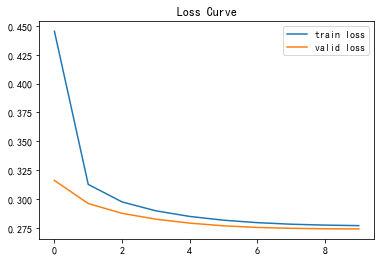

In [18]:
plt.plot(train_loss_list,label='train loss')
plt.plot(valid_loss_list,label='valid loss')
plt.legend()
plt.title('Loss Curve')
plt.show()

+ 验证集准确率可视化

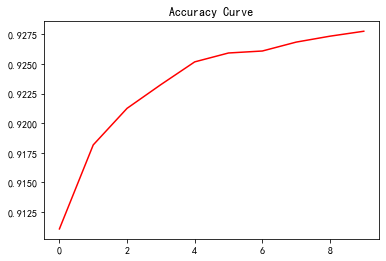

In [19]:
plt.plot(valid_acc_list,label='valid accuracy',c='r')
plt.title('Accuracy Curve')
plt.show()

## 4.测试模型

In [20]:
params = np.load(param_file)

In [21]:
test_nn = net

In [22]:
for i in range(4):   
    test_nn.parameters[i].data = params[str(i)] 

In [23]:
result = test_nn.forward(X_test)

In [24]:
result = np.argmax(result, axis=1)

In [26]:
precision = np.sum(result==Y_test_value) / X_test.shape[0]
print("Precison:", precision)

Precison: 0.9323
